# Node generation

Since id_last_boss_employee and id_last_boss_boss have many categories that cannot be reduced, let's create node embeddings to catch their interactions between them and their employees. They will be conected by gender and work modality as well

## Preparing environment

In [1]:
import pandas as pd
import networkx as nx
from node2vec import Node2Vec as n2v
import sys
sys.path.append('../high_performance_employee_resign_prediction')
from utils import paths

## Importing data

In [2]:
train_df = pd.read_csv(paths.data_interim_dir('train_clean.csv'))
test_df = pd.read_csv(paths.data_interim_dir('test_clean.csv'))

In [3]:
target = train_df['resign']
combined_df = pd.concat([train_df.drop('resign', axis=1), test_df]).reset_index(drop=True)

In [4]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4172 entries, 0 to 4171
Data columns (total 56 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   id_employee_employee          4172 non-null   int64  
 1   id_last_boss_employee         4172 non-null   int64  
 2   seniority_employee            4172 non-null   int64  
 3   work_modality_employee        4172 non-null   object 
 4   office_distance_employee      4172 non-null   float64
 5   low_health_days_employee      4172 non-null   int64  
 6   gender_employee               4172 non-null   object 
 7   recruitment_channel_employee  4172 non-null   object 
 8   average_permanence_employee   4172 non-null   int64  
 9   salary_employee               4172 non-null   int64  
 10  performance_score_employee    4172 non-null   float64
 11  psi_score_employee            4172 non-null   int64  
 12  marital_estatus_employee      4172 non-null   object 
 13  joi

## Creating graph

In [7]:
G = nx.DiGraph()

In [8]:
# Add edges for employee -> boss
for idx, row in combined_df.iterrows():
    G.add_edge(row['id_employee_employee'], row['id_last_boss_employee'])

# Add edges for boss -> boss_of_boss
for idx, row in combined_df.iterrows():
    G.add_edge(row['id_last_boss_employee'], row['id_last_boss_boss'])

# Optionally, add attributes to nodes
for idx, row in combined_df.iterrows():
    G.nodes[row['id_employee_employee']]['gender'] = row['gender_employee']
    G.nodes[row['id_employee_employee']]['work_modality'] = row['work_modality_employee']
    G.nodes[row['id_last_boss_employee']]['gender'] = row['gender_boss']
    G.nodes[row['id_last_boss_employee']]['work_modality'] = row['work_modality_boss']

## Plotting graph

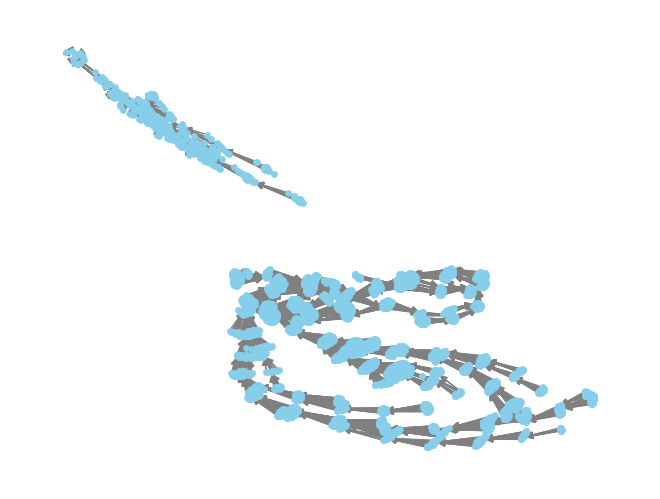

In [9]:
import matplotlib.pyplot as plt

pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=False, node_color='skyblue', node_size=15, edge_color='gray')
plt.show()

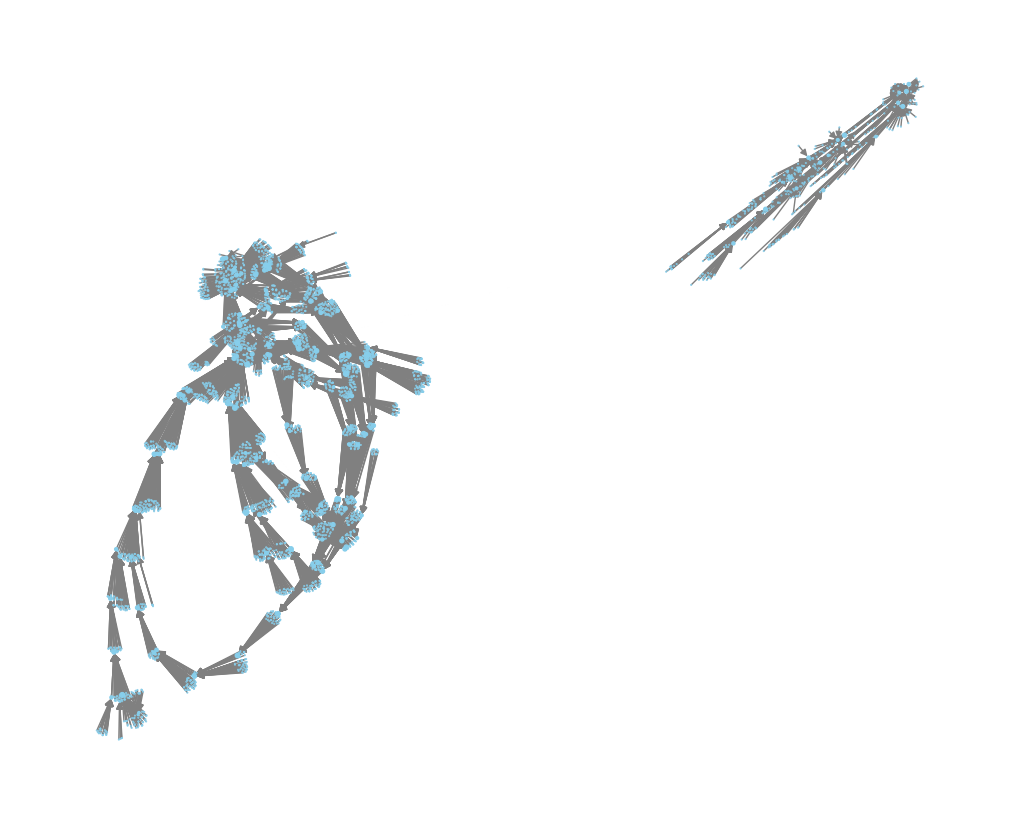

In [10]:
degree_centrality = nx.degree_centrality(G)

# Draw the graph with node size proportional to degree centrality
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G)
node_size = [v * 1000 for v in degree_centrality.values()]
nx.draw(G, pos, with_labels=False, node_color='skyblue', node_size=node_size, edge_color='gray')
plt.show()

## Generating Node Embeddings

In [11]:
# Precompute probabilities and generate walks

node2vec = n2v(G, dimensions=64, walk_length=30, num_walks=200, workers=4)

# Embed nodes
model = node2vec.fit(window=10, min_count=1, batch_words=4)

Computing transition probabilities: 100%|██████████| 4172/4172 [00:00<00:00, 100897.40it/s]


## Storing Node Embeddings

In [12]:
# Extract embeddings for each node
embeddings = {str(node): model.wv[str(node)] for node in G.nodes()}

# Convert embeddings to DataFrame for better visualization and manipulation
embeddings_df = pd.DataFrame.from_dict(embeddings, orient='index')

In [13]:
embeddings_df.index = embeddings_df.index.astype(int)  # Convert index to int if necessary
embeddings_df.reset_index(inplace=True)
embeddings_df.columns = ['id_employee'] + [f'embedding_{i}' for i in range(embeddings_df.shape[1] - 1)]

In [14]:
embeddings_df

,id_employee,embedding_0,embedding_1,embedding_2,embedding_3,embedding_4,embedding_5,embedding_6,embedding_7,embedding_8,...,embedding_54,embedding_55,embedding_56,embedding_57,embedding_58,embedding_59,embedding_60,embedding_61,embedding_62,embedding_63
0,100247,-0.002659,0.003075,0.004799,0.001190,-0.003773,0.000652,-0.002209,0.001867,-0.000495,...,-0.000308,0.000591,-0.003308,0.006727,-0.004634,0.006460,0.001697,0.005337,0.004667,0.005898
1,102074,0.677047,0.605731,0.023487,1.086188,0.889204,1.804250,-2.025474,1.750708,2.366235,...,-0.716250,-0.220192,-3.209752,-3.159858,0.730351,-3.303087,-1.024513,2.300677,-5.333368,-0.059816
2,103355,-0.002487,0.005156,0.006330,-0.000618,-0.004099,0.004332,0.002819,-0.006717,-0.000447,...,0.005486,0.001961,-0.006852,-0.003642,0.007788,0.006094,0.007669,-0.003076,0.005457,-0.007000
3,102115,0.720070,0.066595,0.051830,0.171489,-0.092615,0.501861,1.046146,-0.450965,1.066025,...,-0.544318,0.554244,-1.304216,-0.934792,-0.236829,-1.108315,-1.406671,0.359523,-1.024060,0.219083
4,100669,-0.002317,0.001249,0.002201,0.003939,0.005625,-0.006024,-0.002642,-0.007057,-0.004590,...,0.002628,0.002123,-0.006308,-0.007052,-0.003547,0.000461,-0.004054,-0.007232,-0.002667,-0.005486
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4167,103755,0.004194,0.006509,0.000265,0.005024,-0.006626,-0.006339,-0.000307,-0.006424,0.003355,...,0.006167,-0.003731,-0.005716,0.002722,-0.003524,0.005518,-0.007655,0.007354,-0.003956,0.003426
4168,103976,-0.001847,-0.001745,0.004096,-0.002580,0.003674,0.000156,-0.006211,-0.000783,-0.003256,...,0.002080,-0.001114,0.006468,0.003138,-0.006279,-0.001867,-0.004028,-0.005463,-0.000336,0.000211
4169,104115,-0.005699,0.002142,0.004230,-0.004750,-0.002310,0.005349,-0.006731,-0.003574,0.000952,...,0.003771,0.002983,-0.006643,-0.003003,-0.001826,-0.004924,-0.004840,0.005399,-0.006167,0.002654
4170,103920,-0.004505,0.005152,0.000244,-0.003197,-0.000242,0.006186,0.002341,-0.006723,-0.005564,...,0.001796,0.000294,0.003240,0.003521,-0.003890,-0.006082,0.000841,-0.003451,0.002339,-0.000205


## Merge node embeddings with original data

In [15]:
# Catching id_employee_employee embeddings

final_df = combined_df.merge(embeddings_df, left_on='id_employee_employee', right_on='id_employee', how='left')
final_df.drop('id_employee', axis=1, inplace=True)
final_df.columns = combined_df.columns.tolist() + [f'embedding_employee_{i}' for i in range(embeddings_df.shape[1] - 1)]
columns = final_df.columns.tolist()

# Catching id_boss_employee embeddings

final_df = final_df.merge(embeddings_df, left_on='id_last_boss_employee', right_on='id_employee', how='left')
final_df.drop('id_employee', axis=1, inplace=True)
final_df.columns = columns + [f'embedding_boss_{i}' for i in range(embeddings_df.shape[1] - 1)]
columns = final_df.columns.tolist()

# Catching id_boss_boss embeddings

final_df = final_df.merge(embeddings_df, left_on='id_last_boss_boss', right_on='id_employee', how='left')
final_df.drop('id_employee', axis=1, inplace=True)
final_df.columns = columns + [f'embedding_boss_boss_{i}' for i in range(embeddings_df.shape[1] - 1)]

In [16]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4172 entries, 0 to 4171
Columns: 248 entries, id_employee_employee to embedding_boss_boss_63
dtypes: float32(192), float64(19), int64(27), object(10)
memory usage: 4.8+ MB


## Split back into Train and Test DataFrames

In [17]:
train_new = final_df.loc[:len(train_df)-1,:].reset_index(drop=True)
test_new = final_df.loc[len(train_df):, :].reset_index(drop=True)

In [18]:
train_new = pd.concat([train_new, target], axis=1)

In [19]:
train_new

,id_employee_employee,id_last_boss_employee,seniority_employee,work_modality_employee,office_distance_employee,low_health_days_employee,gender_employee,recruitment_channel_employee,average_permanence_employee,salary_employee,...,embedding_boss_boss_55,embedding_boss_boss_56,embedding_boss_boss_57,embedding_boss_boss_58,embedding_boss_boss_59,embedding_boss_boss_60,embedding_boss_boss_61,embedding_boss_boss_62,embedding_boss_boss_63,resign
0,100247,102074,1,Híbrida,1.760,1,Mujer,Ferias & Networking,1,140011,...,3.298499,-0.994122,-2.263611,-3.378453,2.718830,4.783224,4.877679,2.672090,0.867534,0
1,103355,102115,1,Híbrida,0.760,2,Hombre,Ferias & Networking,2,182774,...,0.722121,-1.917320,-1.656395,-0.248357,-1.389888,-1.423793,0.763635,-1.485826,0.351129,1
2,100669,102060,1,Híbrida,4.950,3,Mujer,Referidos,11,682106,...,0.666079,-1.020842,-0.445005,-0.766734,-1.322476,-0.866561,0.579649,-0.513713,-0.744329,0
3,103760,102062,1,Híbrida,13.030,2,Hombre,Linkedin,2,270232,...,2.313122,-1.612431,-0.930520,-0.494543,-2.170990,-1.186678,0.520833,-1.676865,-0.817508,1
4,100965,102062,1,Híbrida,13.045,2,Hombre,Linkedin,2,266804,...,2.313122,-1.612431,-0.930520,-0.494543,-2.170990,-1.186678,0.520833,-1.676865,-0.817508,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2147,103567,102171,1,Presencial,1.965,8,Mujer,Portal Web,3,281159,...,-0.245182,1.345935,-2.977600,-0.963285,2.400534,0.875441,1.984689,-1.486482,-2.131853,1
2148,104098,102172,1,Presencial,0.805,12,Mujer,Linkedin,13,460337,...,0.321956,1.895023,2.150938,-1.005901,-2.609583,-0.967081,-1.575122,-3.341933,1.987326,1
2149,103987,102155,1,Presencial,1.625,1,Hombre,Portal Web,11,633879,...,0.413008,-0.495254,-0.019623,0.057835,-0.125013,-0.519507,0.514791,-0.046028,-0.011640,1
2150,103810,102141,1,Presencial,5.665,2,Hombre,Portal Web,6,793977,...,1.578644,2.176292,-1.015945,2.241601,1.827106,0.852672,1.184908,2.678687,-2.118327,1


In [20]:
test_new

,id_employee_employee,id_last_boss_employee,seniority_employee,work_modality_employee,office_distance_employee,low_health_days_employee,gender_employee,recruitment_channel_employee,average_permanence_employee,salary_employee,...,embedding_boss_boss_54,embedding_boss_boss_55,embedding_boss_boss_56,embedding_boss_boss_57,embedding_boss_boss_58,embedding_boss_boss_59,embedding_boss_boss_60,embedding_boss_boss_61,embedding_boss_boss_62,embedding_boss_boss_63
0,100486,102115,1,Híbrida,0.795,2,Hombre,Ferias & Networking,2,181654,...,-0.649473,0.722121,-1.917320,-1.656395,-0.248357,-1.389888,-1.423793,0.763635,-1.485826,0.351129
1,103752,102074,1,Híbrida,1.715,1,Mujer,Ferias & Networking,1,140986,...,3.178370,3.298499,-0.994122,-2.263611,-3.378453,2.718830,4.783224,4.877679,2.672090,0.867534
2,103937,102150,1,Híbrida,2.375,1,Hombre,Portal Web,6,406690,...,-0.681639,0.633677,-0.929688,-0.046846,0.020181,-0.217173,-0.801132,1.011762,0.137270,0.107384
3,101744,102172,1,Híbrida,2.185,3,Hombre,Linkedin,3,249107,...,0.395527,0.321956,1.895023,2.150938,-1.005901,-2.609583,-0.967081,-1.575122,-3.341933,1.987326
4,101037,102060,1,Híbrida,4.660,3,Hombre,Referidos,10,698318,...,0.309895,0.666079,-1.020842,-0.445005,-0.766734,-1.322476,-0.866561,0.579649,-0.513713,-0.744329
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015,103755,102161,1,Presencial,2.995,2,Mujer,Portal Web,16,700814,...,-0.771985,0.704235,-0.759871,-0.073130,-0.263452,-0.375608,-0.927331,0.555362,-0.262773,0.182810
2016,103976,102171,1,Presencial,2.775,0,Mujer,Portal Web,5,677071,...,1.694129,-0.245182,1.345935,-2.977600,-0.963285,2.400534,0.875441,1.984689,-1.486482,-2.131853
2017,104115,102144,1,Presencial,3.990,1,Hombre,Portal Web,7,876285,...,0.921936,1.771637,-0.013293,-3.196641,1.690433,0.343448,1.777692,3.097495,-1.989410,-1.721649
2018,103920,102152,1,Presencial,7.100,1,Mujer,Linkedin,8,719102,...,0.617768,1.672095,1.026911,-3.358981,0.575398,0.254098,1.590319,3.000932,-1.811051,-0.026697


## Saving new DataFrames

In [21]:
train_new.to_csv(paths.data_interim_dir('train_node.csv'), index=False, sep=',')
test_new.to_csv(paths.data_interim_dir('test_node.csv'), index=False, sep=',')